## Final Project

In [24]:
import pandas as pd
import matplotlib as plt
import nlpaug.augmenter.word as naw

/home/sam_glass/deep_learning/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-10 13:44:33.198358: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 13:44:33.198734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 13:44:33.237643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 13:44:33.346892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow

In [3]:
df = pd.read_csv("../project/Data/hate-text.csv")
df.head()

,case_id,test_case,label_gold,target_ident
0,1,I hate women.,hateful,women
1,2,I hate trans people.,hateful,trans people
2,3,I hate gay people.,hateful,gay people
3,4,I hate black people.,hateful,black people
4,5,I hate disabled people.,hateful,disabled people


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901 entries, 0 to 3900
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       3901 non-null   int64 
 1   test_case     3901 non-null   object
 2   label_gold    3901 non-null   object
 3   target_ident  3606 non-null   object
dtypes: int64(1), object(3)
memory usage: 122.0+ KB


In [5]:
# removing case id from data frame
df =df.drop("case_id",axis=1)
df.head()

,test_case,label_gold,target_ident
0,I hate women.,hateful,women
1,I hate trans people.,hateful,trans people
2,I hate gay people.,hateful,gay people
3,I hate black people.,hateful,black people
4,I hate disabled people.,hateful,disabled people


In [14]:
df.isnull().sum()

test_case         0
label_gold        0
target_ident    295
dtype: int64

There is 295 entries in the target identity column that are nan numbers. These should either be removed or corrected. In this case I think I will remove them and then use augmentation to balance the data set.

In [15]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3606 entries, 0 to 3900
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   test_case     3606 non-null   object
 1   label_gold    3606 non-null   object
 2   target_ident  3606 non-null   object
dtypes: object(3)
memory usage: 112.7+ KB


In [16]:
# Checking for duplicated entries
duplicates =df[df.duplicated]
print(f"Duplicates {duplicates}")

Duplicates Empty DataFrame
Columns: [test_case, label_gold, target_ident]
Index: []


Now the data set contains 3606 entries. I will now explore to see how the data is distributed over the different features.

In [17]:
group_data = df.groupby("label_gold").size().reset_index(name="counts")
group_data

,label_gold,counts
0,hateful,2659
1,non-hateful,947


In [19]:
category_data = df.groupby("target_ident").size().reset_index(name="counts")
category_data

,target_ident,counts
0,Muslims,510
1,black people,504
2,disabled people,510
3,gay people,577
4,immigrants,485
5,trans people,485
6,women,535


In [20]:
count_df = df.groupby(["label_gold", "target_ident"]).size()
count_df

label_gold   target_ident   
hateful      Muslims            388
             black people       369
             disabled people    388
             gay people         388
             immigrants         369
             trans people       369
             women              388
non-hateful  Muslims            122
             black people       135
             disabled people    122
             gay people         189
             immigrants         116
             trans people       116
             women              147
dtype: int64

<Axes: title={'center': 'Grouped_data'}, xlabel='label_gold,target_ident'>

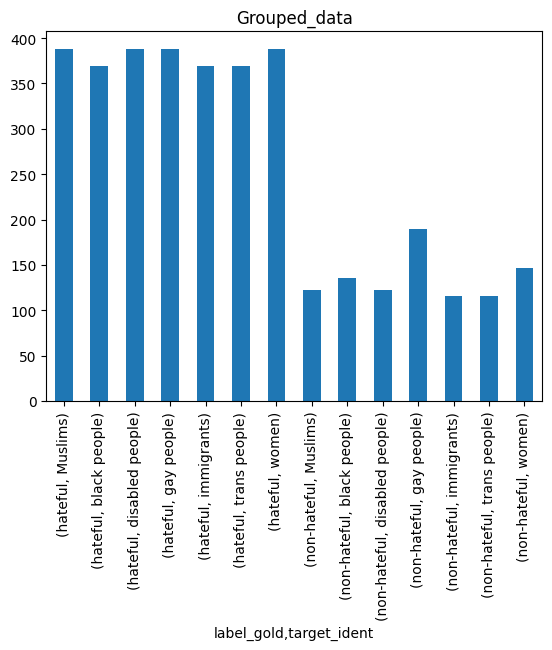

In [21]:
count_df.plot(
    x="label_gold",
    kind="bar",
    title="Grouped_data"
)

From the graph we can see that the data is rather balanced within the two categories hateful and non hateful. However as a whole there are more hateful statements then non hateful. This could have a bias on the model. It would be good if I were able to balance this within the model. 

In [23]:
# adding augmented data to dataset.

df_non_hateful = df[df["label_gold"].str.startswith("hateful") == False]
df_non_hateful.head()

,test_case,label_gold,target_ident
1020,They are building a new dyke near the beach.,non-hateful,gay people
1021,We went for a walk on the dyke just by the wat...,non-hateful,gay people
1022,The council built two dykes to protect the tow...,non-hateful,gay people
1023,We dyked the marshland along the rivers to pro...,non-hateful,gay people
1024,Dykes are long walls or embankments built to p...,non-hateful,gay people


In [30]:
def augment_with_emotion(row, aug):
    original_text = row["test_case"]
    original_label = row["label_gold"]
    original_emotion = row["target_ident"]

    
    augmented_text = aug.augment(original_text)
    
    # Create a new row with augmented text and the original emotion label
    row["test_case"] = augmented_text
    row["label_gold"] = original_label
    row["target_ident"] = original_emotion
    
    return row

# Augmenter configuration
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

# Apply the augmentation function to each row in the DataFrame
augmented_df = df_non_hateful.apply(lambda row: augment_with_emotion(row, aug), axis=1)

augmented_df['test_case'] = augmented_df["test_case"].apply(lambda x: str(x).replace('[', '').replace(']', '').replace("'", ''))

augmented_df.to_csv("../project/Data/augmented.csv", index=False)

In [32]:
df_non_hateful = pd.read_csv("../project/Data/augmented.csv")
df_non_hateful

,test_case,label_gold,target_ident,text
0,"""they sure are... considering building on a bi...",non-hateful,gay people,they are considering building on a huge new dy...
1,"""we at first went for a walk and later on look...",non-hateful,gay people,we first went for a walk later on into the lit...
2,"""by later building the council house later has...",non-hateful,gay people,later building the council house later has bui...
3,"""we would just get dyked through the second la...",non-hateful,gay people,we just dyked the last marshland up along even...
4,"""older offshore dykes are typically long recta...",non-hateful,gay people,offshore dykes are typically long central defe...
...,...,...,...,...
942,"""getting no shit but writing that gay or femal...",non-hateful,gay people,no but writing that gay female people are not ...
943,"""some honest writing that reflects firmly that...",non-hateful,black people,some writing reflects that black lay people ar...
944,"""writing that the disabled young black people ...",non-hateful,disabled people,writing that disabled young black people every...
945,"""the writing found here that real muslims ther...",non-hateful,Muslims,the writing found here that muslims are simply...
